# Natural Language Processsing with a Rule-based Model
NLTK SentimentIntensityAnalyzer is built on the NLTK VADER package and is a rule/lexicon-based sentiment analyzer. The module is built to handle social media data. Pre-processing is handled internally within the modules (i.e. removing punctuation, stopwords, graphics, etc.). VADER was integrated into the NLTK python module

https://www.nltk.org/api/nltk.sentiment.vader.html

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer # rule/lexicon-based sentiment analyzer
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# local imports
from comment_scraper import get_sql_table

c:\Users\keatu\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Test NLTK Vader code on sentiment 140 data for comparison with Naive Bayes model

In [6]:
# constants 
DATA_DIR = 'C:\\Users\\keatu\\Regis_archive\\practicum2_data\\'
dbname = os.path.join(DATA_DIR, "Youtube_Data_msnbc.db")
sia = SentimentIntensityAnalyzer()

In [9]:
# Get same training/test data used in the naive bayes model
s140df = pd.read_csv(os.path.join(DATA_DIR,"resources","s140_processed.csv"), encoding='latin-1')
text=s140df['text']
target=s140df['target']
train_text, test_text, train_label, test_label=train_test_split(text, target, random_state=50)

In [15]:
# Make predictions with Vader
sia = SentimentIntensityAnalyzer()
test_scores = list(map(lambda x: sia.polarity_scores(x)['compound'], train_text))

In [19]:
# bin the scores to positive or negative sentiment to test against s140 data
def pos_neg_bin(score):
    if score < 0:
        return 0 # negative sentiment
    else:
        return 4 # positive sentiment
test_scores_bin = list(map(pos_neg_bin, test_scores))

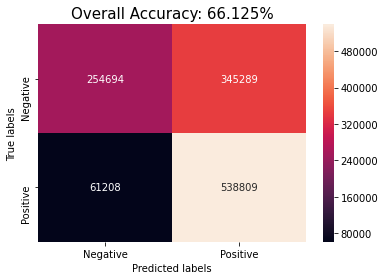

In [25]:
# print results
score = accuracy_score(train_label,test_scores_bin)
conf = confusion_matrix(train_label, test_scores_bin)

ax= plt.subplot()
sns.heatmap(conf, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Overall Accuracy: {:.3f}%'.format(score*100.0), size=15); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [32]:
# combine scraped comments and channel info into one dataframe
comments = get_sql_table('comments', dbname)
comments = comments.replace("nan",0)
videos = get_sql_table('videos',dbname)
videos = videos.replace("nan",0)
combined = comments.merge(videos, on='videoId', how="inner", suffixes=("","_video"))

In [28]:
# show total number of videos in dataframe
print(combined.videoId.nunique())

519


In [44]:
combined.groupby("videoId").aggregate({"likeCount_video":"first"}).reset_index().sort_values('likeCount_video', ascending=False)

,videoId,likeCount_video
336,eYIVMtiBxsU,11897
451,r-7DQAvpFFk,11340
450,qvlmz8NczNU,10859
296,ZEuVKKnRbcQ,10763
405,lmk1vLuHtjQ,10471
...,...,...
470,tXvgD7znE3I,310
368,hyAAYwE-KLs,303
173,LSj7wFwutoM,288
269,VSBISR9mZs0,260


In [50]:
# Take the most popular videos using likeCount
top_videos = combined.groupby("videoId").aggregate({"likeCount_video":"first"}).reset_index().sort_values('likeCount_video', ascending=False).head(10)['videoId'].tolist()
topdf = combined.loc[combined['videoId'].isin(top_videos)]

In [53]:
# Create sentiment nltk analyzer and apply the polarity_scores function on the comments
sia = SentimentIntensityAnalyzer()
topdf['sentiment_score'] = topdf["textOriginal"].apply(lambda x: sia.polarity_scores(x)['compound'])

c:\Users\keatu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


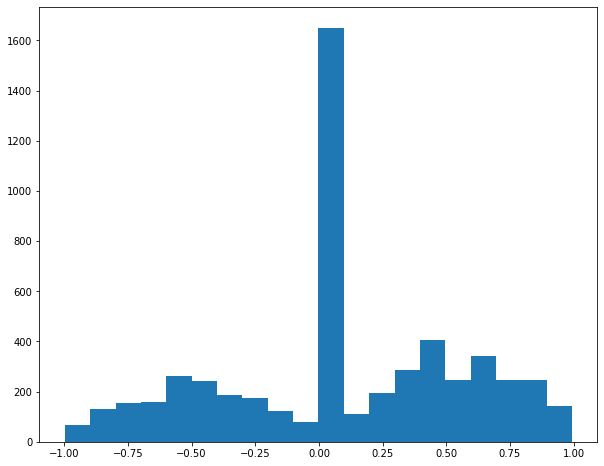

In [54]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(topdf['sentiment_score'], bins=20)
plt.show()

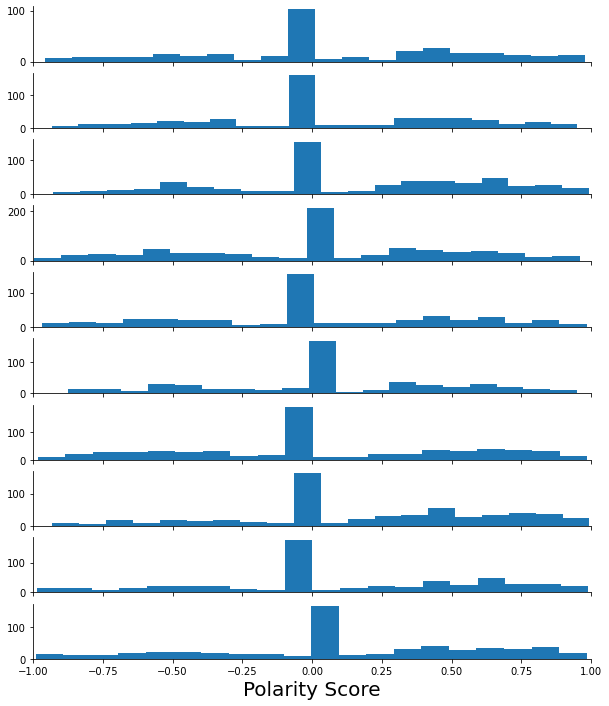

In [65]:
fig = plt.figure(figsize = (10,12))
i = 0
for vid, vid_group in topdf.groupby("videoId"):
    i+=1
    ax = fig.add_subplot(10,1,i)
    #ax.title(vid_group['title'])
    ax.hist(vid_group['sentiment_score'], bins=20)
    ax.set_xlim(-1,1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i!=10:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Polarity Score", size=20)
plt.show()